In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100
EXPECTED_N = [5000,5000,5000,20000]

## Torus model

In [3]:
def simulator(z, center = np.array([0.6, 0.8])):
    r = sum((z[:2]-center)**2)**0.5  # Return radial distance from center
    x = np.array([z[0], r, z[2]])
    return x

def noise(x, z = None, noise = np.array([0.03, 0.005, 0.2])):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.57, 0.8, 1.0])
zdim = len(z0)
x0 = simulator(z0)  # Using Asimov data

In [4]:
cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)

Creating new cache.


## Inference

In [5]:
intensity = None

for i in range(4):
    if intensity is None:
        intensity = swyft.get_unit_intensity(expected_n=EXPECTED_N[i], dim=zdim)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N[i],
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    cache.grow(intensity)
    cache.simulate(simulator)
    points = swyft.Points(cache, intensity, noise)
    re = swyft.RatioEstimator(points, device=DEVICE)
    re.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4])

Simulate:   4%|▍         | 228/5092 [00:00<00:02, 2271.82it/s]

Adding 5092 new samples. Run simulator!


Simulate: 100%|██████████| 5092/5092 [00:01<00:00, 2956.89it/s]


yshape (shape of features between head and legs): 3
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 77.93413782119751
Validation loss: 69.61757326126099
Validation loss: 67.4960446357727
Validation loss: 66.22866034507751
Validation loss: 66.00837349891663
Validation loss: 66.12910866737366
Total epochs: 6
LR iteration 1
Validation loss: 62.146138191223145
Validation loss: 61.987754106521606
Validation loss: 64.38459062576294
Total epochs: 3
LR iteration 2
Validation loss: 62.34717035293579
Validation loss: 61.91058611869812
Validation loss: 62.18818712234497
Total epochs: 3


Simulate:   7%|▋         | 300/4384 [00:00<00:01, 2995.71it/s]

Constrained posterior area: 0.1200154942446131
Adding 4384 new samples. Run simulator!


Simulate: 100%|██████████| 4384/4384 [00:01<00:00, 3015.50it/s]


yshape (shape of features between head and legs): 3
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 106.06361198425293
Validation loss: 91.29194498062134
Validation loss: 90.3671932220459
Validation loss: 89.64372491836548
Validation loss: 89.21331882476807
Validation loss: 89.3541350364685
Total epochs: 6
LR iteration 1
Validation loss: 86.88426446914673
Validation loss: 87.26397275924683
Total epochs: 2
LR iteration 2
Validation loss: 86.40985059738159
Validation loss: 85.45307493209839
Validation loss: 84.93553304672241
Validation loss: 85.63706684112549
Total epochs: 4


Simulate: 100%|██████████| 41/41 [00:00<00:00, 3082.44it/s]

Constrained posterior area: 0.11904696368100702
Adding 41 new samples. Run simulator!
yshape (shape of features between head and legs): 3
Start training
No new simulator runs required.
LR iteration 0


Validation loss: 99.43237972259521
Validation loss: 93.53606700897217
Validation loss: 93.22464752197266
Validation loss: 90.60463380813599
Validation loss: 89.57156896591187
Validation loss: 88.5763030052185
Validation loss: 90.47735357284546
Total epochs: 7
LR iteration 1
Validation loss: 88.02028751373291
Validation loss: 88.16174125671387
Total epochs: 2
LR iteration 2
Validation loss: 87.69746828079224
Validation loss: 87.14991044998169
Validation loss: 88.93762111663818
Total epochs: 3


Simulate:   2%|▏         | 329/15299 [00:00<00:04, 3289.81it/s]

Constrained posterior area: 0.11160351162533542
Adding 15299 new samples. Run simulator!


Simulate: 100%|██████████| 15299/15299 [00:04<00:00, 3094.32it/s]


yshape (shape of features between head and legs): 3
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 370.8788981437683
Validation loss: 370.4604158401489
Validation loss: 356.84596014022827
Validation loss: 356.42640924453735
Validation loss: 353.9214816093445
Validation loss: 354.21881341934204
Total epochs: 6
LR iteration 1
Validation loss: 348.52601385116577
Validation loss: 344.0579490661621
Validation loss: 348.14678621292114
Total epochs: 3
LR iteration 2
Validation loss: 342.1284508705139
Validation loss: 341.8658332824707
Validation loss: 342.1448302268982
Total epochs: 3


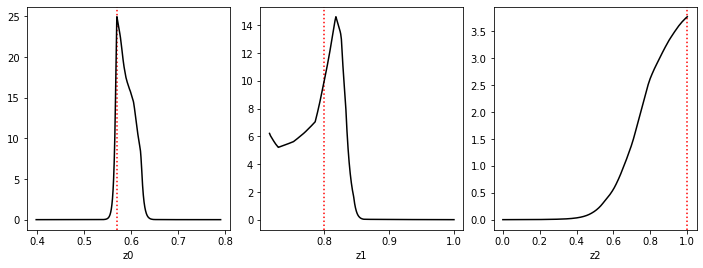

In [6]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (12, 4),max_n_points=10000);

In [7]:
re2 = swyft.RatioEstimator(points, combinations = [[0, 1], [0, 2], [1, 2]], device=DEVICE)

yshape (shape of features between head and legs): 3


In [8]:
re2.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4])

Start training
LR iteration 0
Validation loss: 283.8841061592102
Validation loss: 251.61608052253723
Validation loss: 245.02117729187012
Validation loss: 230.04992866516113
Validation loss: 224.18616271018982
Validation loss: 222.18211841583252
Validation loss: 227.08247780799866
Total epochs: 7
LR iteration 1
Validation loss: 213.54248905181885
Validation loss: 202.28130531311035
Validation loss: 204.30941891670227
Total epochs: 3
LR iteration 2
Validation loss: 197.61708545684814
Validation loss: 195.47735118865967
Validation loss: 197.46024000644684
Total epochs: 3


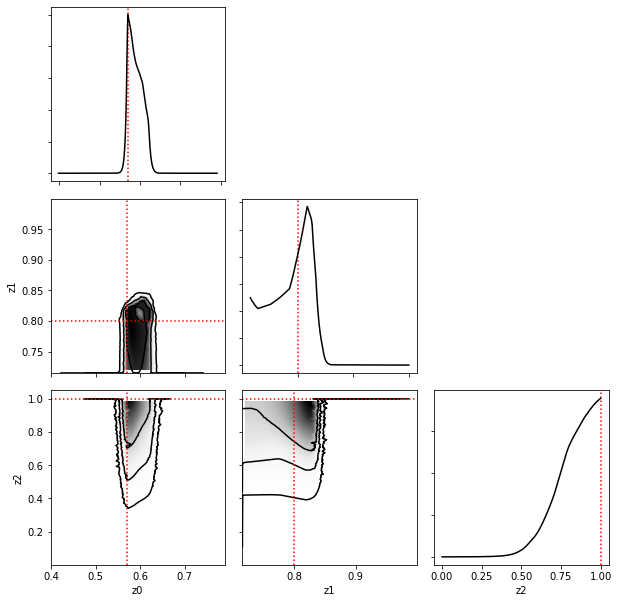

In [9]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 10,max_n_points=10000)